# 3D Eye-Tracking Scene Animation

This notebook demonstrates an animated 3D view of the eye-tracking scene, rotating from right lateral to left lateral position over 5 seconds at 30 fps.

## Imports and Setup

In [ ]:
%matplotlib widget

import seet.device as device
import seet.scene as scene
import seet.user as user
import seet.visualization.scene_visualization as scene_visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
import os
import sys
sys.path.append("..")
import utils

dropdown_widget = utils.get_experiment_info(save_results=False)

RadioButtons(description='Device:', options=('default',), value='default')

## Create Scene Model

In [5]:
# Create a scene
scene_file_name, _ = \
    utils.get_configuration_files(dropdown_widget.value)  # type: ignore

et_scene = scene.SceneModel(parameter_file_name=scene_file_name)

print(f"Scene loaded from: {scene_file_name}")
print(f"Number of eyes: {len(et_scene.user.eyes)}")
print(f"Number of subsystems: {len(et_scene.device.subsystems)}")

Scene loaded from: C:\Users\padossa\repos\seet-1\seet\scene\default_scene/default_scene.json
Number of eyes: 2
Number of subsystems: 2


## Animated 3D Scene (Complex Camera Path)

Animate the 3D scene with an interesting camera path that includes:
1. **Lateral sweep**: Right to left lateral view (0° → 180°)
2. **Return journey**: Left back to right lateral view (180° → 0°)  
3. **Top-down sweep**: Right to left from aerial view (0° → 180° with high elevation)
4. **Return to start**: Left back to right returning to original elevation (180° → 0°)

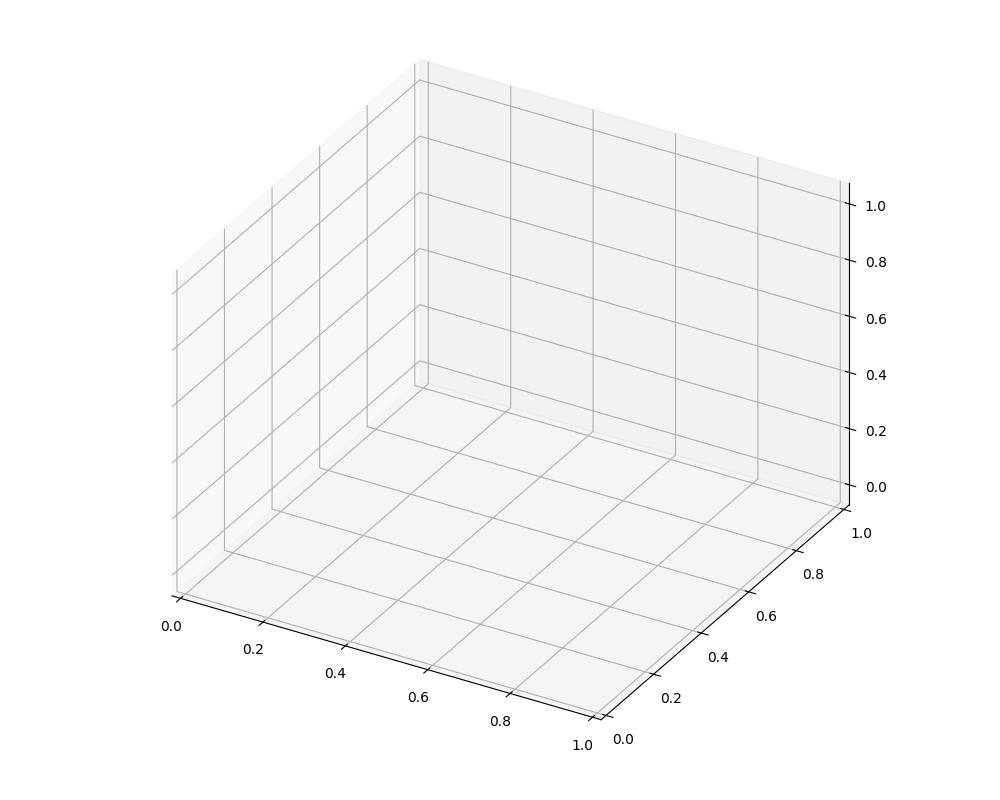

Complex animation path includes:
1. Lateral sweep: Right to Left (3 seconds)
2. Return journey: Left to Right (3 seconds)
3. Top-down sweep: Right to Left from aerial view (3 seconds)
4. Return to start: Left to Right, lowering to original view (3 seconds)
Total duration: 12 seconds at 30 fps (360 frames)

CREATING SIMPLE ANIMATION (First segment only)
Saving simple animation to eye_tracking_simple_animation.mp4 using FFmpeg...
Simple animation saved successfully as eye_tracking_simple_animation.mp4

Simple animation: 90 frames, 3 seconds duration
Simple animation shows: Right to Left lateral sweep (0° → 180°)

CREATING COMPLEX ANIMATION (All four segments)
Saving complex animation to eye_tracking_complex_animation.mp4 using FFmpeg...
Complex animation saved successfully as eye_tracking_complex_animation.mp4

ANIMATION SUMMARY
✓ Simple animation saved: eye_tracking_simple_animation.mp4
  - Duration: 3 seconds
  - Content: Right to Left lateral sweep only
✓ Complex animation saved: eye_

In [6]:
# Create figure for animation
fig_anim = plt.figure(figsize=(10, 8))
ax_anim = fig_anim.add_subplot(
    1, 1, 1,
    projection="3d",
    proj_type="ortho",
    computed_zorder=True
)

# Animation parameters - 30 fps for longer duration to accommodate complex path
fps = 30
duration_seconds = 12  # Extended to 12 seconds for the complex camera path
num_frames = fps * duration_seconds  # 360 frames for 12 seconds at 30 fps
interval_ms = 1000 / fps             # ~33.33ms for 30 fps

# Define the complex camera path with 4 segments
segment_frames = num_frames // 4  # 90 frames per segment (3 seconds each)

def get_camera_position(frame):
    """Calculate camera azimuth and elevation for complex path"""
    segment = frame // segment_frames
    local_frame = frame % segment_frames
    progress = local_frame / (segment_frames - 1) if segment_frames > 1 else 0
    progress = max(0, min(1, progress))  # Clamp to [0, 1]
    
    if segment == 0:
        # Segment 1: Right to Left Lateral (0° → 180°, low elevation)
        azim = 0 + 180 * progress
        elev = 15
        description = "Lateral Sweep (R→L)"
        
    elif segment == 1:
        # Segment 2: Left to Right Lateral (180° → 0°, low elevation)
        azim = 180 - 180 * progress
        elev = 15
        description = "Return Journey (L→R)"
        
    elif segment == 2:
        # Segment 3: Right to Left from Top (0° → 180°, high elevation)
        azim = 0 + 180 * progress
        elev = 75  # High elevation for top-down view
        description = "Top-down Sweep (R→L)"
        
    else:  # segment == 3
        # Segment 4: Left to Right returning to original elevation (180° → 0°, elev 75→15)
        azim = 180 - 180 * progress
        elev = 75 - 60 * progress  # Gradually lower elevation from 75° to 15°
        description = "Return to Start (L→R)"
    
    return azim, elev, description

# Create visualization object
et_scene_vis_anim = scene_visualization.SceneModelVisualization(
    et_scene, ax_anim, visualization_node=et_scene
)

def animate(frame):
    """Animation function with complex camera path"""
    # Clear the axes
    ax_anim.clear()
    
    # Get camera position for this frame
    azim, elev, description = get_camera_position(frame)
    
    # Set view
    ax_anim.view_init(azim=azim, elev=elev, vertical_axis="y")
    
    # Recreate visualization object for this frame
    et_scene_vis_frame = scene_visualization.SceneModelVisualization(
        et_scene, ax_anim, visualization_node=et_scene
    )
    
    # Visualize
    et_scene_vis_frame.visualize()
    
    # Set labels and title with current segment info
    ax_anim.set_xlabel("X (mm)")
    ax_anim.set_ylabel("Y (mm)")
    ax_anim.set_zlabel("Z (mm)")
    
    # Progress indicator
    overall_progress = (frame + 1) / num_frames * 100
    segment_num = (frame // segment_frames) + 1
    ax_anim.set_title(f"Eye-Tracking Scene Animation\n"
                     f"{description} | Azim: {azim:.1f}° Elev: {elev:.1f}°\n"
                     f"Segment {segment_num}/4 | Progress: {overall_progress:.1f}%")
    
    return []

# Create animation
anim = animation.FuncAnimation(
    fig_anim, animate, frames=num_frames, 
    interval=interval_ms, blit=False, repeat=True
)

plt.tight_layout()
plt.show()

print(f"Complex animation path includes:")
print(f"1. Lateral sweep: Right to Left (3 seconds)")
print(f"2. Return journey: Left to Right (3 seconds)")
print(f"3. Top-down sweep: Right to Left from aerial view (3 seconds)")
print(f"4. Return to start: Left to Right, lowering to original view (3 seconds)")
print(f"Total duration: {duration_seconds} seconds at {fps} fps ({num_frames} frames)")

# First, create and save the simple animation (just the first segment)
print("\n" + "="*60)
print("CREATING SIMPLE ANIMATION (First segment only)")
print("="*60)

def animate_simple(frame):
    """Animation function for simple lateral sweep only"""
    # Clear the axes
    ax_anim.clear()
    
    # Only use first segment (lateral sweep)
    progress = frame / (segment_frames - 1) if segment_frames > 1 else 0
    progress = max(0, min(1, progress))
    
    azim = 0 + 180 * progress  # Right to Left Lateral (0° → 180°)
    elev = 15                  # Low elevation
    description = "Lateral Sweep (R→L)"
    
    # Set view
    ax_anim.view_init(azim=azim, elev=elev, vertical_axis="y")
    
    # Recreate visualization object for this frame
    et_scene_vis_frame = scene_visualization.SceneModelVisualization(
        et_scene, ax_anim, visualization_node=et_scene
    )
    
    # Visualize
    et_scene_vis_frame.visualize()
    
    # Set labels and title
    ax_anim.set_xlabel("X (mm)")
    ax_anim.set_ylabel("Y (mm)")
    ax_anim.set_zlabel("Z (mm)")
    
    # Progress indicator for simple animation
    simple_progress = (frame + 1) / segment_frames * 100
    ax_anim.set_title(f"Eye-Tracking Scene Animation (Simple)\n"
                     f"{description} | Azim: {azim:.1f}° Elev: {elev:.1f}°\n"
                     f"Progress: {simple_progress:.1f}%")
    
    return []

# Create simple animation (just first segment)
anim_simple = animation.FuncAnimation(
    fig_anim, animate_simple, frames=segment_frames,
    interval=interval_ms, blit=False, repeat=True
)

# Save simple animation
simple_animation_saved = False

# Try MP4 with FFmpeg writer first for simple animation
if not simple_animation_saved:
    try:
        simple_mp4_filename = "eye_tracking_simple_animation.mp4"
        print(f"Saving simple animation to {simple_mp4_filename} using FFmpeg...")
        writer = animation.FFMpegWriter(fps=fps, bitrate=1800)
        anim_simple.save(simple_mp4_filename, writer=writer)
        print(f"Simple animation saved successfully as {simple_mp4_filename}")
        simple_animation_saved = True
    except Exception as e:
        print(f"Could not save simple animation as MP4 with FFmpeg: {e}")

# Try AVI format for simple animation
if not simple_animation_saved:
    try:
        simple_avi_filename = "eye_tracking_simple_animation.avi"
        print(f"Trying to save simple animation as AVI: {simple_avi_filename}...")
        writer = animation.FFMpegWriter(fps=fps, codec='libx264')
        anim_simple.save(simple_avi_filename, writer=writer)
        print(f"Simple animation saved successfully as {simple_avi_filename}")
        simple_animation_saved = True
    except Exception as e:
        print(f"Could not save simple animation as AVI: {e}")

if not simple_animation_saved:
    print("Failed to save simple animation. Will proceed with complex animation.")

print(f"\nSimple animation: {segment_frames} frames, 3 seconds duration")
print("Simple animation shows: Right to Left lateral sweep (0° → 180°)")

# Now save the full complex animation
print("\n" + "="*60)
print("CREATING COMPLEX ANIMATION (All four segments)")
print("="*60)

# Recreate the complex animation object
anim_complex = animation.FuncAnimation(
    fig_anim, animate, frames=num_frames, 
    interval=interval_ms, blit=False, repeat=True
)

# Save complex animation with different format options
complex_animation_saved = False

# Try MP4 with FFmpeg writer first for complex animation
if not complex_animation_saved:
    try:
        complex_mp4_filename = "eye_tracking_complex_animation.mp4"
        print(f"Saving complex animation to {complex_mp4_filename} using FFmpeg...")
        writer = animation.FFMpegWriter(fps=fps, bitrate=2500)  # Higher bitrate for longer video
        anim_complex.save(complex_mp4_filename, writer=writer)
        print(f"Complex animation saved successfully as {complex_mp4_filename}")
        complex_animation_saved = True
    except Exception as e:
        print(f"Could not save complex animation as MP4 with FFmpeg: {e}")

# Try AVI format for complex animation
if not complex_animation_saved:
    try:
        complex_avi_filename = "eye_tracking_complex_animation.avi"
        print(f"Trying to save complex animation as AVI: {complex_avi_filename}...")
        writer = animation.FFMpegWriter(fps=fps, codec='libx264')
        anim_complex.save(complex_avi_filename, writer=writer)
        print(f"Complex animation saved successfully as {complex_avi_filename}")
        complex_animation_saved = True
    except Exception as e:
        print(f"Could not save complex animation as AVI: {e}")

# Try MP4 with PillowWriter for complex animation
if not complex_animation_saved:
    try:
        complex_mp4_filename = "eye_tracking_complex_animation.mp4"
        print(f"Trying complex animation MP4 with PillowWriter: {complex_mp4_filename}...")
        writer = animation.PillowWriter(fps=fps)
        anim_complex.save(complex_mp4_filename, writer=writer)
        print(f"Complex animation saved successfully as {complex_mp4_filename}")
        complex_animation_saved = True
    except Exception as e:
        print(f"Could not save complex animation MP4 with PillowWriter: {e}")

# Fallback to GIF for complex animation
if not complex_animation_saved:
    try:
        complex_gif_filename = "eye_tracking_complex_animation.gif"
        print(f"Falling back to GIF for complex animation: {complex_gif_filename}...")
        writer = animation.PillowWriter(fps=fps)
        anim_complex.save(complex_gif_filename, writer=writer)
        print(f"Complex animation saved successfully as {complex_gif_filename}")
        complex_animation_saved = True
    except Exception as e:
        print(f"Could not save complex animation as GIF: {e}")

if not complex_animation_saved:
    print("Failed to save complex animation in any format. Check if FFmpeg is installed.")
    print("Install FFmpeg: conda install ffmpeg  or  pip install ffmpeg-python")

# Summary
print("\n" + "="*60)
print("ANIMATION SUMMARY")
print("="*60)
if simple_animation_saved:
    print("✓ Simple animation saved: eye_tracking_simple_animation.mp4")
    print("  - Duration: 3 seconds")
    print("  - Content: Right to Left lateral sweep only")
else:
    print("✗ Simple animation failed to save")

if complex_animation_saved:
    print("✓ Complex animation saved: eye_tracking_complex_animation.mp4")
    print("  - Duration: 12 seconds")
    print("  - Content: Complete 4-segment camera path")
else:
    print("✗ Complex animation failed to save")

print("\nNote: Animations may take a moment to render due to complexity.")